In [266]:
import pandas as pd
import os
from matplotlib import pyplot
import matplotlib.colors as mcolors
import matplotlib
import math
from matplotlib.pyplot import figure
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
from google.cloud import storage
from google.cloud.storage import Blob

In [842]:
def tmalign_hist(metrics, num_results=10, show_control=False, bin_size=100, version='top_score', select_clusters=None, cmap='viridis', name=''):
    '''
    Arguments:
    - metrics: A Pandas DataFrame in the form pairwise_evaluation_metrics.parquet + a "cluster" column.
    
    Optional Arguments:
    - num_results: Default 10. Number of clusters to plot. Ignored if version is set to "select".
    - show_control: Default False. Whether to plot tmalign scores from the random control dataset.
    - bin_size: Default 100. Number of bins on historgram.
    - version: Default "top_score". Options also include "top_pair_count", "random" and "select" (if passed, argument select_clusters is required).
    - select_clusters: A list of integer cluster labels. Required if version is set to "select".
    - cmap: Default "viridis". The name of the Matplotlib colormap to apply to the plot.
    - name: Default "". Name of experiment, ex.: "SEQVEC + HDBSCAN".
    
    Output:
    - A Pyplot histogram to stdout.
    - List of cluster labels shown on plot.
    '''
    subtitle = ''
    figure(figsize=(10, 6))
    pyplot.style.use('default')

    if version == 'top_score':
        interesting_clusters = metrics[['cluster', 'tmalign_score']].groupby(['cluster']).mean(['tmalign_score']).reset_index().sort_values(
        by=['tmalign_score'], ascending=False)[:num_results].cluster.values
        subtitle = f'\nTop {num_results} Clusters by Score'
    elif version == 'top_pair_count':
        interesting_clusters = metrics[['cluster', 'target_protein']].groupby(['cluster']).count().reset_index().sort_values(by=['target_protein'], ascending=False)[:num_results].cluster.values
        subtitle = f'\nTop {num_results} Clusters by Num. of Protein Pairs'
    elif version == 'random':
        interesting_clusters = metrics[['cluster', 'target_protein']].groupby(['cluster']).count().reset_index().sample(num_results).cluster.values
        subtitle = f'\nRandom {num_results} Clusters'
    elif version == 'select':
        interesting_clusters = select_clusters
        subtitle = f'\nSelect {len(interesting_clusters)} Clusters'
    else:
        return None

    ssize = int(len(metrics[metrics.cluster.isin(interesting_clusters)])*0.5)
    colors = pyplot.get_cmap(cmap, len(interesting_clusters))
    
    interesting_clusters.sort()
    
    if name != "":
        name = ' (' + name + ')'
    
    for i, cluster in enumerate(interesting_clusters):
        pyplot.hist(metrics[metrics.cluster == cluster].tmalign_score, bins=bin_size, alpha=0.5, label=f'Cluster {cluster}', range=(0,1), color=colors(i))

    if show_control:
        sample_all = pd.read_parquet('/home/jupyter/pss/tmalign_rmsd_full.parquet')
        pyplot.hist(sample_all.sample(ssize).tm_score_norm_ref_p1.astype(float), bins=bin_size, alpha=0.5, label='Control', range=(0,1))
        pyplot.title('TM-Align Score Distributions: Control vs Experiment' + name + subtitle)
    else:
        pyplot.title('TM-Align Score Distributions' + name + subtitle)

    p = pyplot.ylim()[1] * 0.75
    pyplot.legend(loc='upper left')
    pyplot.xlabel('TM-Align Score')
    pyplot.ylabel('Num. Protein Pairs')
    pyplot.vlines(0.5, 0, pyplot.ylim()[1], linestyles='dashed', colors='k')
    pyplot.text(0.51, p, 'Similarity Significance\nThreshold')
    pyplot.vlines(0.17, 0, pyplot.ylim()[1], linestyles='dashed', colors='k')
    pyplot.text(0.18, p, 'Random Noise')
    pyplot.show();
    
    return interesting_clusters

In [882]:
def tmalign_scatter(metrics, num_results=10, version='top_score_tmalign', select_clusters=None, cmap='viridis', name=""):
    '''
    Arguments:
    - metrics: A Pandas DataFrame in the form pairwise_evaluation_metrics.parquet + a "cluster" column.
    
    Optional Arguments:
    - num_results: Default 10. Number of clusters to plot. Ignored if version is set to "select".
    - version: Default "top_score_tmalign". Options also include "top_score_rmsd", "top_pair_count", "random" and "select" (if passed, argument select_clusters is required).
               Note: Only the equivalent of num_results = len(metrics.cluster.unique()) is currently implemented.
    - select_clusters: A list of integer cluster labels. Required if version is set to "select".
    - cmap: Default "viridis". The name of the Matplotlib colormap to apply to the plot.
    - name: Default "". Name of experiment, ex.: "SEQVEC + HDBSCAN".
    
    Output:
    - A Pyplot scatter plot to stdout.
    - List of cluster labels shown on plot.
    '''
    subtitle = ''
    figure(figsize=(10, 6))
    pyplot.style.use('default')
    
    subtitle = f'\nSelect {len(metrics.cluster.unique())} Clusters'
    focus = metrics.cluster.unique()
    focus.sort()
    colors = pyplot.get_cmap(cmap, len(focus))
    #colors = list(mcolors.cnames.keys())[::-1]
    
    if name != "":
        name = ' (' + name + ')'
    
    for i, cluster in enumerate(focus):
        t = metrics[metrics.cluster == cluster]
        pyplot.scatter(x=t.tmalign_score, y=t.rmsd, alpha=0.5, label=f'Cluster {cluster}', color=colors(i))

    pyplot.legend(loc='upper left')
    pyplot.xlim(left=0, right=1)
    pyplot.ylim(bottom=0, top=10)
    pyplot.vlines(0.5, 0, 3, linestyles='dashed', colors='k')
    pyplot.hlines(3, 0.5, 1, linestyles='dashed', colors='k')
    pyplot.text(0.5, 3.2, 'Strong Similarity Zone')
    pyplot.xlabel('TM-Align Score')
    pyplot.ylabel('RMSD')
    pyplot.title('TM-Align Score vs RMSD' + name + subtitle)
    pyplot.show();
    
    return focus

In [900]:
dir_files = [n.split('.')[0] for n in os.listdir('/home/jupyter/pss/tmp/') if not n in ['.ipynb_checkpoints', 'Untitled.ipynb', 'TMalign.cpp', 'blast_annotations.parquet']]
res = pd.DataFrame(None)
for file in dir_files:
    res = res.append(pd.read_parquet(f'/home/jupyter/pss/tmp/{file}.parquet'))
print('Experiment:', len(res), 'out of 14338 processed')

Experiment: 14338 out of 14338 processed


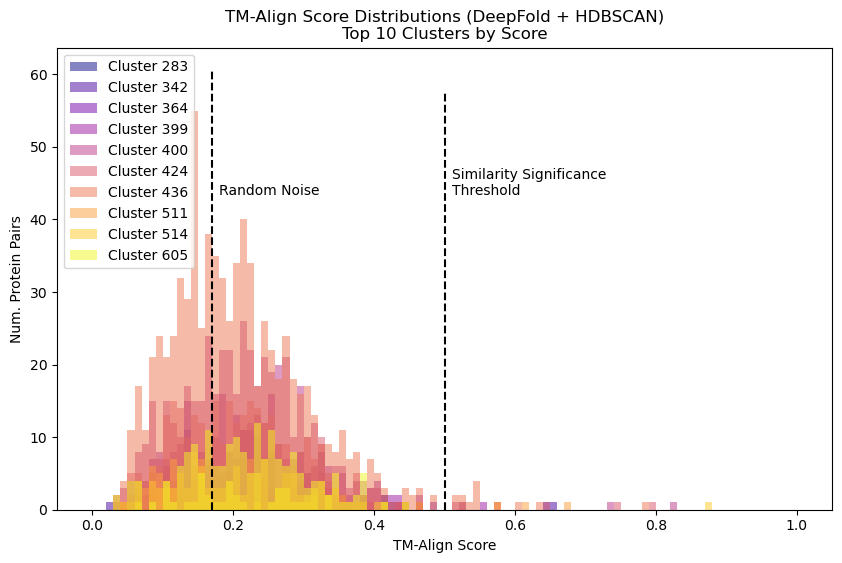

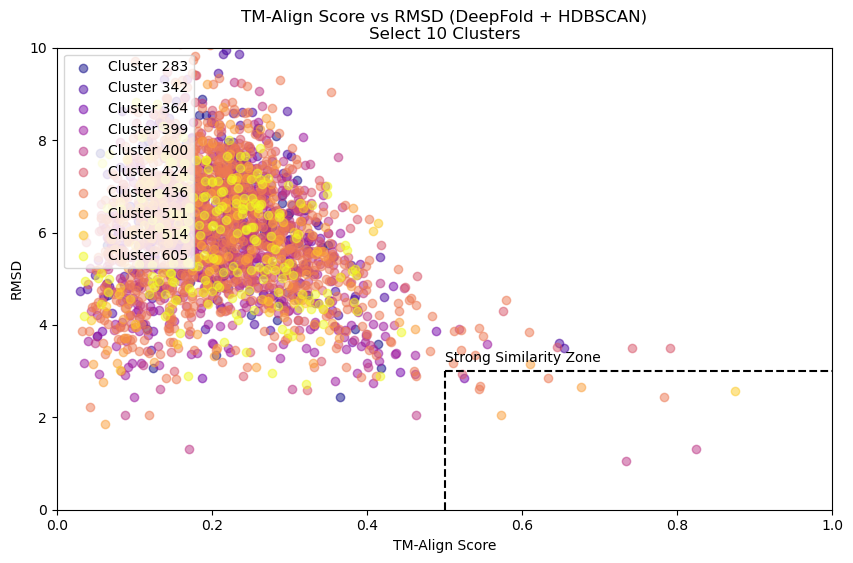

In [902]:
cmap = 'plasma'
name = "DeepFold + HDBSCAN"
plot_1_clusters = tmalign_hist(res, version='top_score', num_results=10, cmap=cmap, name=name)
plot_2_clusters = tmalign_scatter(res[res.cluster.isin(plot_1_clusters)], cmap=cmap, name=name)

In [903]:
# Highest number of processed protein pairs per cluster
res[['cluster', 'target_protein']].groupby(['cluster']).count().reset_index().sort_values(by=['target_protein'], ascending=False)[:10]

,cluster,target_protein
19,519,2182
21,550,2178
0,-1,2136
16,486,2078
11,432,1309
12,436,780
20,521,484
9,400,469
10,424,318
25,595,283


In [904]:
# Highest mean tmalign scores for processed pairs by cluster
res[['cluster', 'tmalign_score']].groupby(['cluster']).mean(['tmalign_score']).reset_index().sort_values(by=['tmalign_score'], ascending=False)[:10]

,cluster,tmalign_score
4,283,0.225544
7,364,0.223282
8,399,0.220088
27,605,0.219724
9,400,0.214816
10,424,0.212579
6,342,0.210823
18,514,0.209267
17,511,0.208457
12,436,0.208174


In [905]:
print(len(res))
res.head()

14338


,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tmalign_score,cluster
0,AF-Q99627-F1-model_v1,209,AF-Q9BQ48-F1-model_v1,92,42,4.42,0.13612,519
1,AF-Q7Z601-F1-model_v1,462,AF-Q86WK6-F1-model_v1,493,149,7.95,0.17848,550
2,AF-Q8NGC6-F1-model_v1,315,AF-Q9UI43-F1-model_v1,246,123,6.34,0.23282,486
3,AF-Q9UBG7-F1-model_v1,517,AF-Q9NZ20-F1-model_v1,509,190,7.84,0.21282,479
4,AF-O94818-F1-model_v1,638,AF-Q9UBK7-F1-model_v1,228,106,6.12,0.11981,436


In [906]:
batch_stats = pd.read_parquet('/home/jupyter/pss/pairwise_evaluation_metrics.parquet')
print(len(batch_stats))
batch_stats.head()

301072


,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tmalign_score
0,AF-Q8N1S5-F1-model_v1,342,AF-P48449-F1-model_v1,732,190,7.43,0.30487
1,AF-Q8N1S5-F1-model_v1,342,AF-Q8N6C7-F1-model_v1,128,70,5.22,0.14206
2,AF-Q8N1S5-F1-model_v1,342,AF-Q9NW08-F1-model_v1,1133,156,6.86,0.26120
3,AF-Q8N1S5-F1-model_v1,342,AF-C9J3I9-F1-model_v1,102,48,3.15,0.12211
4,AF-Q8N1S5-F1-model_v1,342,AF-Q02930-F1-model_v1,508,123,6.88,0.20843


In [907]:
new_batch_stats = batch_stats.append(res.drop(['cluster'], axis=1))
print(len(new_batch_stats))
new_batch_stats.head()

315410


,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tmalign_score
0,AF-Q8N1S5-F1-model_v1,342,AF-P48449-F1-model_v1,732,190,7.43,0.30487
1,AF-Q8N1S5-F1-model_v1,342,AF-Q8N6C7-F1-model_v1,128,70,5.22,0.14206
2,AF-Q8N1S5-F1-model_v1,342,AF-Q9NW08-F1-model_v1,1133,156,6.86,0.26120
3,AF-Q8N1S5-F1-model_v1,342,AF-C9J3I9-F1-model_v1,102,48,3.15,0.12211
4,AF-Q8N1S5-F1-model_v1,342,AF-Q02930-F1-model_v1,508,123,6.88,0.20843


In [908]:
new_batch_stats.drop_duplicates(inplace=True)
print(len(new_batch_stats))

315410


In [909]:
table = pa.Table.from_pandas(new_batch_stats)
pq.write_table(table, f'/home/jupyter/pss/pairwise_evaluation_metrics.parquet')
len(pd.read_parquet('/home/jupyter/pss/pairwise_evaluation_metrics.parquet'))

315410

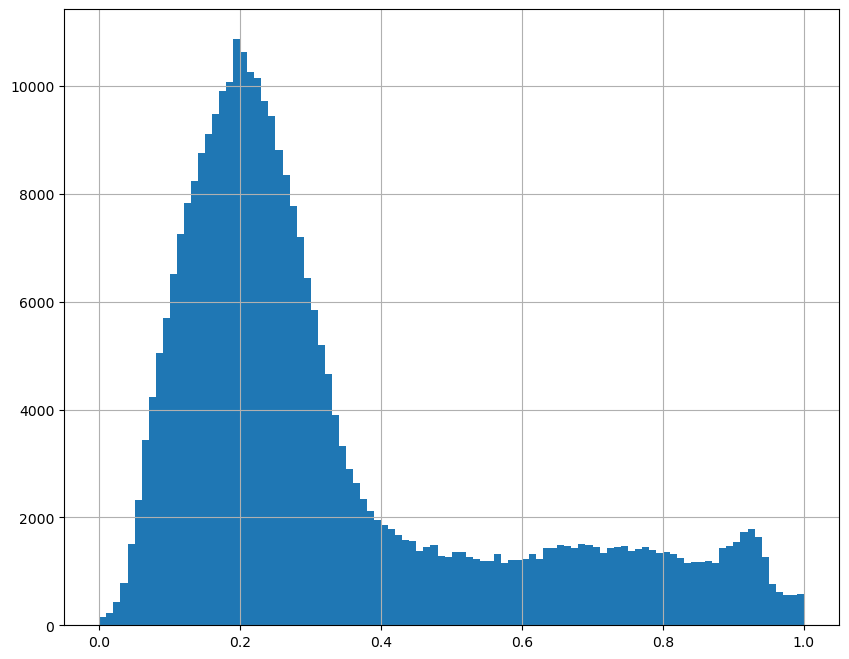

In [910]:
new_batch_stats.tmalign_score.hist(bins=100, figsize=(10,8));